### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### standard values

In [2]:
gate_ctt = np.array([165, 315, 465, 615, 765, 915, 1065, 1215, 1365, 1515], dtype = int)

In [3]:
#gate_ct = np.array([46, 88, 130, 172, 214, 256, 298, 340, 382, 424], dtype = int)

In [4]:
g_en5 = -7.711545013271975

In [5]:
nseeds = 10

In [6]:
dep = np.arange(1, 11, 1, dtype = int)

In [7]:
base_expo = [[1,6], [5,6], [1,5], [5,5], [1,4], [5,4], [1,3]]

In [8]:
eps = [b[0]*(10**(-b[1])) for b in base_expo]

In [9]:
perr = []
exp_off = []
for yt in range(len(eps)):
    p_er = np.array(1 - (1-eps[yt])**gate_ctt)
    perr.append(perr)
    exp_off.append(1 - p_er)

### noiseless data

In [10]:
with open('noiseless_COBY_rand_runs.pkl', 'rb') as file:
    yruns = pickle.load(file)

In [11]:
with open('noiseless_COBY_rand_list.pkl', 'rb') as file:
    ylist = pickle.load(file)

In [12]:
res_data_idm = []
res_data_ids = []
val_list_idm = []
val_list_ids = []

In [13]:
for gt in dep:
    yran = np.array(yruns['%s'%gt])
    ylis = np.array(ylist['%s'%gt])
    # Compute mean and standard deviation across runs
    mean_y = np.mean(yran, axis=0)
    std_y = np.std(yran, axis=0)
    val = np.mean(ylis, axis=0)
    val_std = np.std(ylis, axis=0)
    res_data_idm.append(mean_y)
    res_data_ids.append(std_y)
    val_list_idm.append(val)
    val_list_ids.append(val_std)

### noisy data

In [15]:
noisy_data_mean = {}
noisy_data_std = {}
noisy_data_val_m = {}
noisy_data_val_s = {}
for gt in range(len(base_expo)):
    #with open('global_noisy_seeds_gates/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
    with open('global_noisy_gates_COBY_seeds_assumptions/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
        res = pickle.load(file)
    res_data_mean = []
    res_data_std = []
    val_list = []
    val_std = []
    for pt in dep:
        yran = []
        ylis = []
        for ht in np.arange(0, nseeds, 1, dtype = int):
            re = eval(res['%s'%ht][pt-1].meta_data['optimization_trace'])
            vv = res['%s'%ht][pt-1].value
            app = [vv for yt in range(25000-len(re))]
            yran.append(re + app)
            ylis.append(vv)
        yseed_opt = np.array(yran)
        yseed_val = np.array(ylis)
        mean_y = np.mean(yseed_opt, axis=0)
        std_y = np.std(yseed_opt, axis=0)
        val = np.mean(yseed_val, axis=0)
        val_sig = np.std(yseed_val, axis=0)
        res_data_mean.append(mean_y)
        res_data_std.append(std_y)
        val_list.append(val)
        val_std.append(val_sig)
    noisy_data_mean['%s'%gt] = res_data_mean
    noisy_data_std['%s'%gt] = res_data_std
    noisy_data_val_m['%s'%gt] = val_list
    noisy_data_val_s['%s'%gt] = val_std

### selected noiseless data plot

In [16]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [17]:
plt.rcParams.update({'font.size': 16})

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_18892\2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


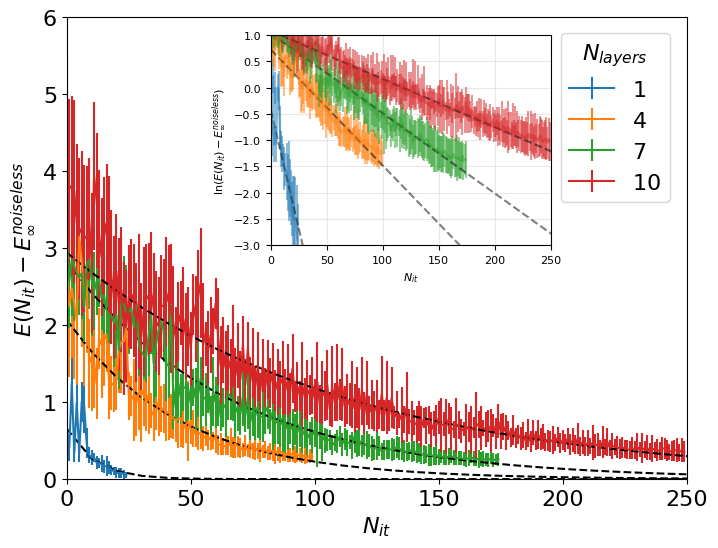

In [19]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.38, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype=int)
fit_ran = 25

for gt in range(0, len(res_data_idm), 3):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)

    # Plot in main axes
    ax.errorbar(xp, yp, yerr=std_devs, fmt='-', label=r'$%s$' %(gt+1))
    
    # Plot fitted exponential model in main axes
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    ax.plot(x_fit, y_fit, '--k')
    
    # Plot in inset (log-linear)
    inset_ax.errorbar(xp, np.log(yp), yerr=std_devs/yp, fmt='-', alpha=0.5)
    inset_ax.plot(x_fit, np.log(y_fit), '--k', alpha=0.5)

# Main axes settings
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 6)
ax.legend(bbox_to_anchor=(0.99, 0.99), title=r'$N_{layers}$')

# Inset axes settings
inset_ax.set_xlim(0, 250)
inset_ax.set_ylim(-3, 1)
inset_ax.set_xlabel(r'$N_{it}$', fontsize=8)
inset_ax.set_ylabel(r'$\ln(E(N_{it}) - E_{\infty}^{noiseless})$', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.grid(True, alpha=0.3)
plt.savefig('figs/noiseless_E_t_inset.pdf', bbox_inches='tight')
plt.show()

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_18892\2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\cqtv201\AppData\Local\Temp\ipykernel_18892\2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


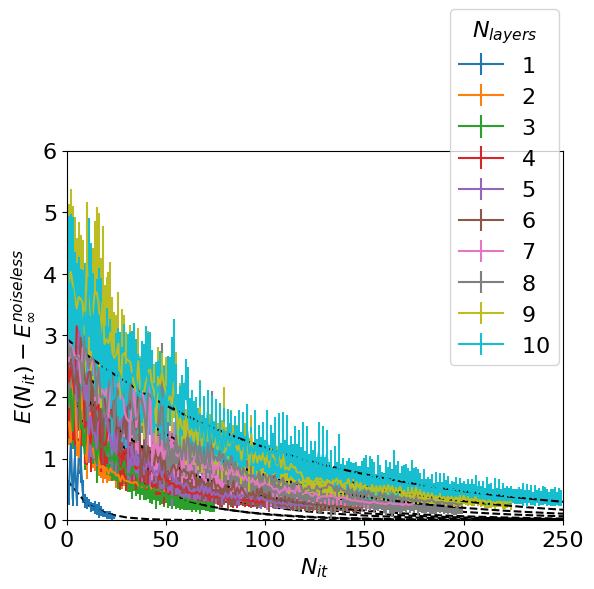

In [25]:
#fitting using the mean data with error propagation
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 25
for gt in range(0, len(res_data_idm), 1):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)
    #y_fit = exp_model(xp, a, b)

    plt.errorbar(xp, yp, yerr=std_devs, fmt='-', label = r'$%s$' %(gt+1))

    # Plot fitted exponential model
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit, '--k', label= r'$F~%s~Layer$' %(gt+1))
    plt.plot(x_fit, y_fit, '--k')

#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
plt.axis([0, 250, 0, 6])
#ax.legend(ncol = 2, bbox_to_anchor = (1, 0.1))
ax.legend(bbox_to_anchor = (0.75, 0.39), title = r'$N_{layers}$')
#plt.savefig('COBYLA_plots/noiseless_E_t.pdf', bbox_inches = 'tight')
plt.show()

### fitting convergence rate

In [26]:
n_lay = 10

In [27]:
# Define power law
def power_model(x, a, b):
    return a * ((x)**-b)

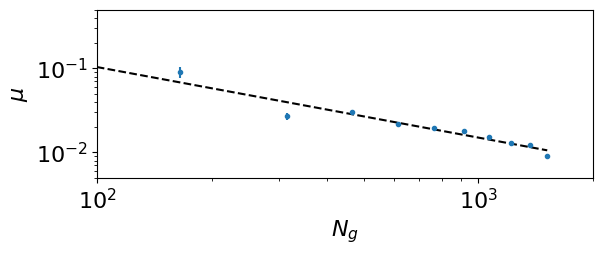

In [28]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.errorbar(gate_ctt[0:n_lay], gam[0:n_lay], yerr=gam_err[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(power_model, gate_ctt[0:n_lay], gam[0:n_lay], sigma=gam_err[0:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = power_model(gate_ctt[0:n_lay], a, b)

residuals = np.array(gam[0:n_lay]) - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(gam_err[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum(( np.array(gam[0:n_lay])-np.mean( np.array(gam[0:n_lay])))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$ \mu$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([100,2000])
ax.set_ylim([0.005,0.5])
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.show()

In [29]:
print(a, a_err, b, b_err)

4.954908170273581 1.0523717689905523 0.8395214736140428 0.030453158371816773


In [30]:
print(r_sq, chi_sq)

0.8682372677212402 0.6517591053446958


### selected noisy data plot

In [31]:
sel = 3

In [32]:
base_expo[sel]

[5, 5]

In [33]:
res_data_mean = noisy_data_mean['%s'%sel]
res_data_std = noisy_data_std['%s'%sel]
val_list = noisy_data_val_m['%s'%sel]

In [34]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_18892\2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


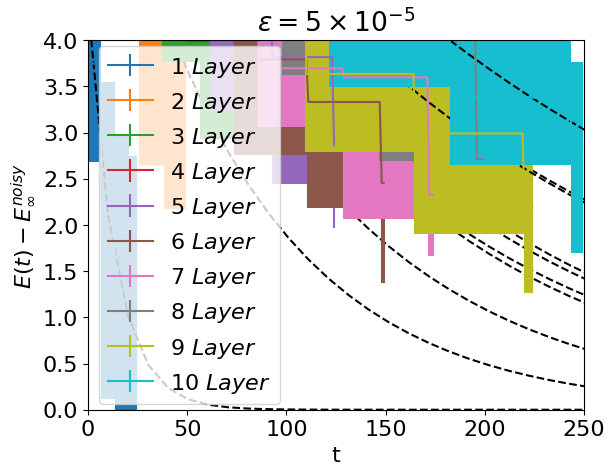

In [35]:
#fitting using the mean data with error propagation
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
alp = []
alp_err = []
E00 = []
E00_err = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 25
for gt in range(0, len(res_data_mean), 1):
#for gt in [3]:
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_mean[gt])-val_list[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_std[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    alp_err.append(b_err)
    alp.append(b)
    E00.append(a)
    E00_err.append(a_err)
    #y_fit = exp_model(xp, a, b)

    plt.errorbar(xp, yp, yerr=std_devs, fmt='-', label = r'$%s~Layer$' %(gt+1))

    # Plot fitted exponential model
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit, '--k', label= r'$F~%s~Layer$' %(gt+1))
    plt.plot(x_fit, y_fit, '--k')

plt.title(r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
#ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel(r'$ E(t) - E_{\infty}^{noisy}$')
plt.axis([0, 250, 0, 4])
#ax.legend(ncol = 2, bbox_to_anchor = (1, 0.1))
ax.legend()
#plt.savefig('noisy_alpha.pdf', bbox_inches = 'tight')
plt.show()

In [36]:
E00

[0.6236441471979547,
 1.3093878344339738,
 1.5738341098643702,
 1.496043705118217,
 1.629742512146026,
 1.768611043783408,
 1.726612890551108,
 2.0665760593578635,
 1.995790207765465,
 2.0199240719437674]

In [37]:
E00_err

[0.09182730514926342,
 0.10047815570869846,
 0.10960593326170617,
 0.11552025757980708,
 0.0836295384719898,
 0.09781852320788575,
 0.10992201168793769,
 0.07804225389341708,
 0.07348753571654298,
 0.0654564459299229]

In [38]:
alp

[0.08853106045660537,
 0.023848961984594155,
 0.025312617641271386,
 0.021580319077501187,
 0.01797306193353103,
 0.016320973914541577,
 0.01451195458073547,
 0.014233109861385056,
 0.011670114816297575,
 0.010809951145524582]

In [39]:
alp_err

[0.013018901536693406,
 0.002576993176474148,
 0.0018481665861522908,
 0.0013076501067429676,
 0.0007214061898620607,
 0.0006757044326217475,
 0.0006976883267638826,
 0.00031607091610115376,
 0.0003053803053234724,
 0.00032440059525896026]

### fitting starting value E00

In [40]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(b * x)

In [41]:
# Define exponential model
def lin_model(x, a, b):
    return a * x + b

In [42]:
# Define power law
def power_model(x, a, b):
    return a * ((x)**b)

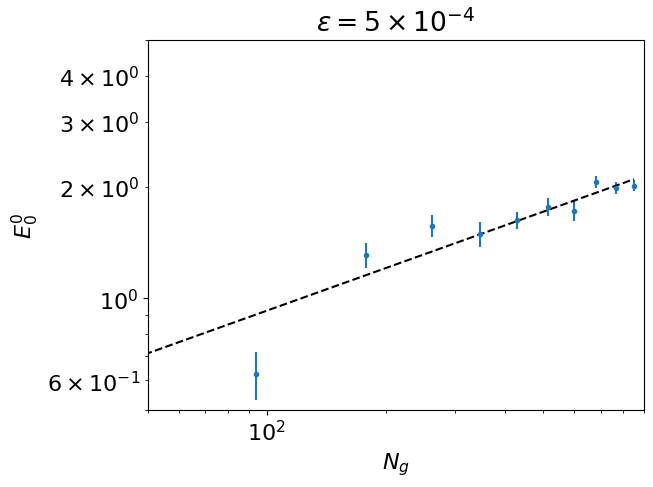

In [43]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#plt.plot(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 'o')
plt.errorbar(gate_ctt[0:n_lay], np.array(E00), yerr = np.array(E00_err), fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(power_model, gate_ctt[0:n_lay], E00, sigma=E00_err, absolute_sigma=True)
#pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(E00), sigma=np.divide(E00_err, np.array(E00)), absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
#y_fit = exp_model(x_fit, np.exp(b), a)
y_fit = power_model(x_fit, a, b)

#a_err = np.exp(b_er)
#b_err = a_er

#y_fitt = exp_model(gate_ctt[0:n_lay], np.exp(b), a)
y_fitt = power_model(gate_ctt[0:n_lay], a, b)


residuals = np.array(E00) - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(E00_err)))
ss_res = np.sum(residuals**2)
ss_tot = np.sum(np.array(E00)-np.mean(np.array(E00))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{0}^0$')
plt.title( r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50,900])
ax.set_ylim([0.5, 5])
#plt.savefig('noiseless_conv_en_fit.pdf', bbox_inches = 'tight')
plt.show()

In [44]:
r_sq

1.0195397800654498

In [45]:
a

0.15892407231928912

In [46]:
b

0.3828020171807391

### fitting noisy $\alpha$

In [47]:
n_lay = 10

In [48]:
# Define power law
def power_model(x, a, b):
    return a * ((x)**-b)

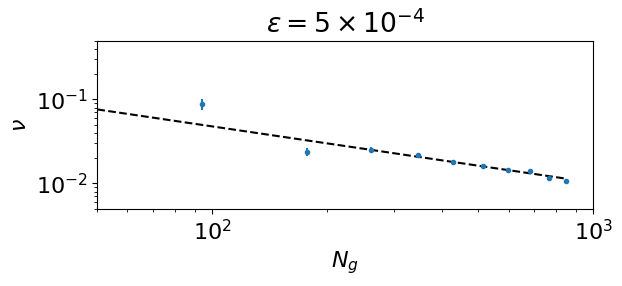

In [49]:
#fitting power law on noisy alpha
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.errorbar(gate_ctt[0:n_lay], alp[0:n_lay], yerr=alp_err[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(power_model, gate_ctt[0:n_lay], alp[0:n_lay], sigma=alp_err[0:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = power_model(gate_ctt[0:n_lay], a, b)

residuals = np.array(alp[0:n_lay]) - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(alp_err[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum(( np.array(alp[0:n_lay])-np.mean(np.array(alp[0:n_lay])))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$ \nu$')
plt.title( r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50,1000])
ax.set_ylim([0.005,0.5])
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.show()

In [50]:
print(a, a_err, b, b_err)

1.0469749981230712 0.23337591046805412 0.6702836704269973 0.034603530203872725


In [51]:
print(r_sq, chi_sq)

0.6701128632928843 0.7738785611694938


### for all $\epsilon$

In [52]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [53]:
alp_list = []
alp_err_list = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 15
for gt in range(len(base_expo)):
    res_data_mean = noisy_data_mean['%s'%gt]
    res_data_std = noisy_data_std['%s'%gt]
    val_list = noisy_data_val_m['%s'%gt]
    #fitting using the mean data with error propagation
    alp = []
    alp_err = []
    for gt in range(0, len(res_data_mean), 1):
        fit_range = (gt+1)*fit_ran
        yy = np.array(res_data_mean[gt])-val_list[gt]
        xp = xx[0:fit_range]
        yp = yy[0:fit_range]
        std_devs = res_data_std[gt][0:fit_range]
        # Fit model with weights
        params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
        a, b = params
        a_err, b_err = np.sqrt(np.diag(cv))
        alp_err.append(b_err)
        alp.append(b)
    alp_list.append(alp)
    alp_err_list.append(alp_err)

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_41016\2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\cqtv201\AppData\Local\Temp\ipykernel_41016\2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


In [54]:
import itertools
marker = itertools.cycle(('o', 'v', 's', 'd', '*', '^', 'x', 'p')) 

In [55]:
# Define fit model
def power_model(x, a, b):
    #return a * np.exp(-b * x)
    return a * ((x)**b)

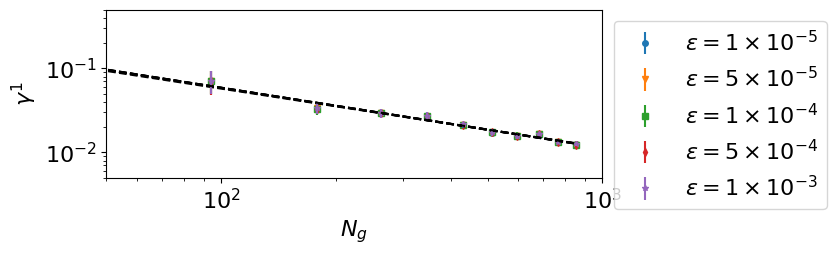

In [56]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []
for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[0:n_lay], alp_list[gt][0:n_lay], yerr=alp_err_list[gt][0:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(power_model, gate_ctt[0:n_lay], alp_list[gt][0:n_lay], sigma=alp_err_list[gt][0:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
    y_fit = power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    y_fitt = power_model(gate_ctt[0:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][0:n_lay]) - y_fitt
    chi_sq = np.sum(np.divide(residuals, np.array(alp_err_list[gt][0:n_lay])))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(( np.array(alp_list[gt][0:n_lay])-np.mean(np.array(alp_list[gt][0:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.legend(bbox_to_anchor = (1, 1))
ax.set_ylabel(r'$ \gamma^1$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50,1000])
ax.set_ylim([0.005,0.5])
#plt.savefig('noisy_alpha_fit.pdf', bbox_inches = 'tight')
plt.show()

In [57]:
alp_fit

[1.442065966483373,
 1.5645299212074693,
 1.604855549609932,
 1.5577020838270663,
 1.5784163274252418]

In [58]:
alp_err_fit

[0.5188803379759808,
 0.5603688538854416,
 0.5687566606653536,
 0.5540317980427811,
 0.5615933573679612]

In [59]:
bet_fit

[-0.6997147281972478,
 -0.7127374029347727,
 -0.71739870752009,
 -0.7121726740104752,
 -0.7135917677125048]

In [60]:
bet_err_fit

[0.055843814378385793,
 0.05561432312258227,
 0.0549846983950476,
 0.05520011070939848,
 0.05524893892172604]

In [61]:
rsq

[0.9385581309088298,
 0.9506399091003309,
 0.9463391213022788,
 0.9468804232315502,
 0.9508097540592374]

In [62]:
csq

[0.07010215232980588,
 -0.07121194898621364,
 0.2363949284139213,
 0.08591669927754098,
 -0.006245450711968803]

In [63]:
np.mean(alp_fit)

1.5495139697106164

In [64]:
np.mean(alp_err_fit)

0.5527262015875036

In [65]:
np.mean(bet_fit)

-0.7111230560750181

In [66]:
np.mean(bet_err_fit)

0.055378377105428034

In [67]:
strt = 0

FileNotFoundError: [Errno 2] No such file or directory: 'COBYLA_plots/noisy_alpha_fit_COBY.pdf'

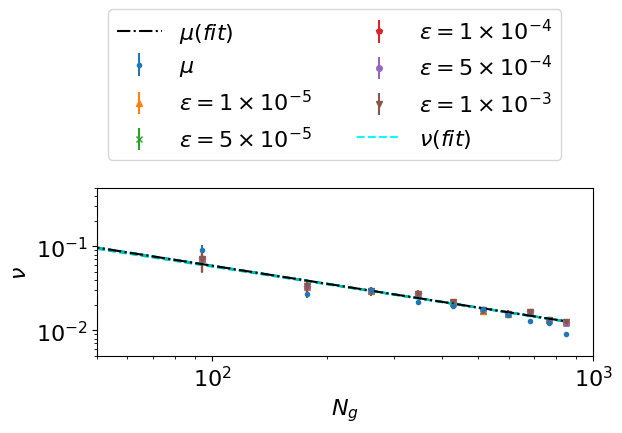

In [87]:
import matplotlib.lines as mlines

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []

plt.errorbar(gate_ctt[strt:n_lay], gam[strt:n_lay], yerr=gam_err[strt:n_lay], fmt='.',  label = r'$\mu$')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(power_model, gate_ctt[strt:n_lay], gam[strt:n_lay], sigma=gam_err[strt:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = power_model(gate_ctt[strt:n_lay], a, b)

resi_0 = np.array(gam[strt:n_lay]) - y_fitt
chi_sq_0 = np.sum(np.divide(resi_0, np.array(gam_err[strt:n_lay])))
ss_res_0 = np.sum(resi_0**2)
ss_tot_0 = np.sum(( np.array(gam[strt:n_lay])-np.mean( np.array(gam[strt:n_lay])))**2)
r_sq_0 = 1 - (ss_res_0 / ss_tot_0)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)


for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], yerr=alp_err_list[gt][strt:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(power_model, gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], sigma=alp_err_list[gt][strt:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
    y_fit = power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    y_fitt = power_model(gate_ctt[strt:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][strt:n_lay]) - y_fitt
    chi_sq = np.sum(np.divide(residuals, np.array(alp_err_list[gt][strt:n_lay])))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((np.array(alp_list[gt][strt:n_lay])-np.mean(np.array(alp_list[gt][strt:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--c', lw=1.5)

# Plot regression line
ax.plot(x_fit, y_fit, '-.k', lw=1.5, label = r'$\mu (fit)$');

# Add an extra line in the legend
l4 = mlines.Line2D([], [], color="cyan", linestyle="--", label = r"$\nu(fit)$")

# Get existing handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Add the extra line to the handles
handles.append(l4)

# Create the legend with all lines
plt.legend(handles=handles, ncol = 2, bbox_to_anchor = (0, 1.1))

ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
#plt.legend(bbox_to_anchor = (0.1, 1.1), ncol =3)
ax.set_ylabel(r'$ \nu$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([50, 1000])
ax.set_ylim([0.005, 0.5])
plt.savefig('COBYLA_plots/noisy_alpha_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

### difference in E(t) noisy and noiseless

In [68]:
xx = np.arange(1, 25001, 1, dtype =int)

In [69]:
sel = 2

-0.0006498279740164747
-5.6490817636653644e-05
0.0036623676909641797
0.03546502465771655
0.0017938079690829375
-0.019068271568088206
0.03793926757738392
-0.0018304073223330787
0.0571996566647594
0.09620486780699132


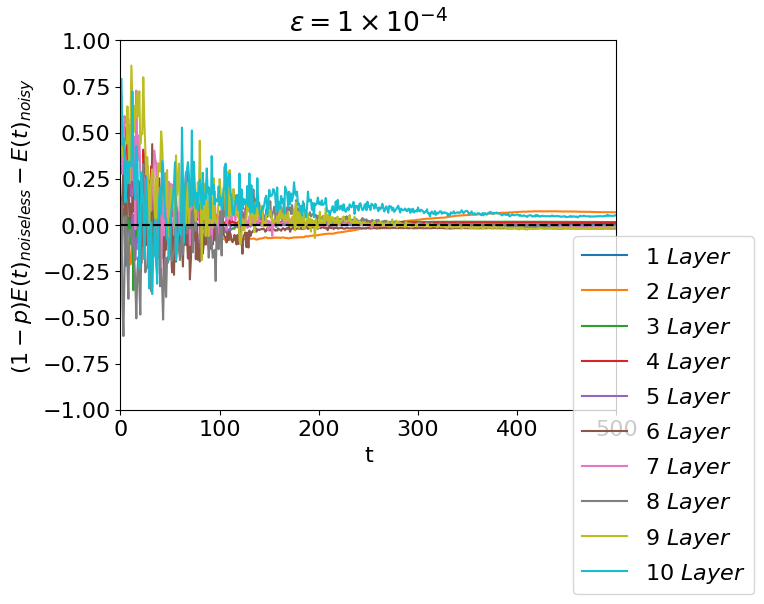

In [70]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for gt in dep:
    diff = np.multiply(exp_off[sel][gt-1], np.array(res_data_idm[gt-1]))- np.array(noisy_data_mean['%s'%sel][gt-1])
    #print(np.multiply(exp_off[sel][gt-1], res_data_idm[gt-1][-1]) - np.min(res_data_mean[gt-1]))
    #diff = np.multiply(exp_off[sel][gt-1]*np.ones(len(res_data_idm[gt-1])), np.array(res_data_idm[gt-1]))- np.array(res_data_mean[gt-1])
    print(np.mean(diff[0:500]))
    ax.plot(xx, diff, label = r'$%s~Layer$' %(gt))
ax.set_xlabel('t')
ax.set_ylabel(r'$ (1-p)E(t)_{noiseless}- E(t)_{noisy}$')
ax.legend(ncol = 1, bbox_to_anchor = (1.3, 0.5))
plt.axis([0, 500, -1, 1])
#ax.set_yscale('log')
plt.title( r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
plt.axhline(0, color = 'k', xmin = 0, xmax = 25000, linestyle = '--')
#plt.savefig('opt_trace_diff.pdf', bbox_inches = 'tight')
plt.show()

### difference in $E_\infty$ noisy and noiseless

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_41016\2050509980.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


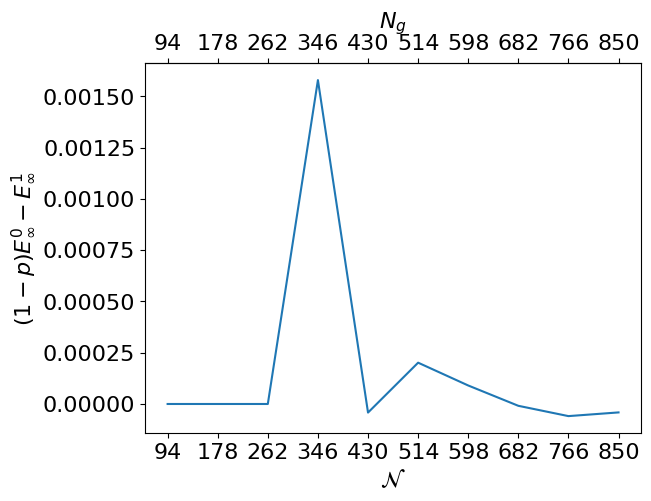

In [71]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
diff = np.multiply(np.array(exp_off[sel]), np.array(val_list_idm)) - np.array(noisy_data_val_m['%s'%sel])
ax.plot(gate_ctt, diff)
ax.set_xlabel('$\mathcal{N}$')
ax.set_ylabel(r'$ (1-p)E_{\infty}^0 - E_{\infty}^1$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
#ax.legend(ncol = 2, bbox_to_anchor = (1.5, 0.25))
#plt.axis([0, 5000, -0.5, 0.5])
#ax.set_yscale('log')
plt.show()

### $E_\infty$ as a function of $\mathcal{N}$

In [72]:
import itertools
marker = itertools.cycle(('o-', 'v-', 's-', 'd-', '*-', '^-', 'x-', 'p-')) 

C:\Users\cqtv201\AppData\Local\Temp\ipykernel_41016\4216337875.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


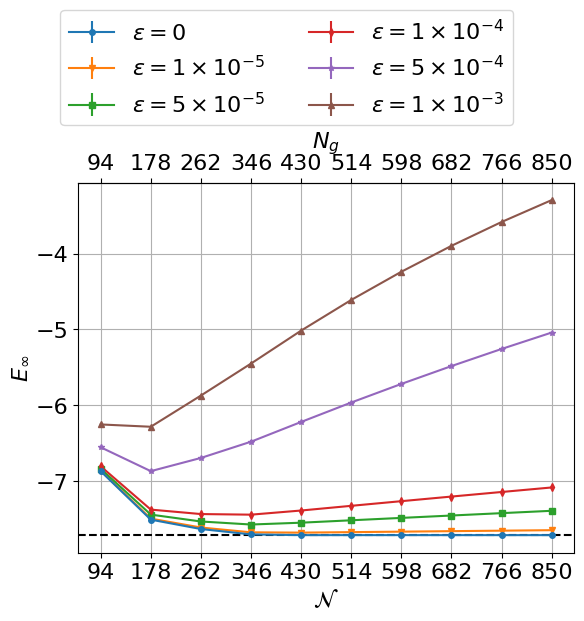

In [73]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.plot(gate_ct, val_list_id, label = r'$\epsilon = 0$')
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt = next(marker), markersize=4, label = r'$\epsilon = 0$')
for rt in range(len(base_expo)):
    #ax.plot(gate_ct, np.array(noisy_data_val['%s'%rt]), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
    #ax.plot(gate_ct, np.multiply(exp_off[rt], val_list_id), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    #diff =  np.multiply(exp_off[rt], val_list_id) - np.array(noisy_data_val['%s'%rt])
    #ax.plot(gate_ct, diff, label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_xlabel(r'$\mathcal{N}$')
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
plt.legend(ncol = 2, bbox_to_anchor = (0.9, 1.5))
#ax.set_yscale('log')
plt.grid()
#plt.savefig('noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

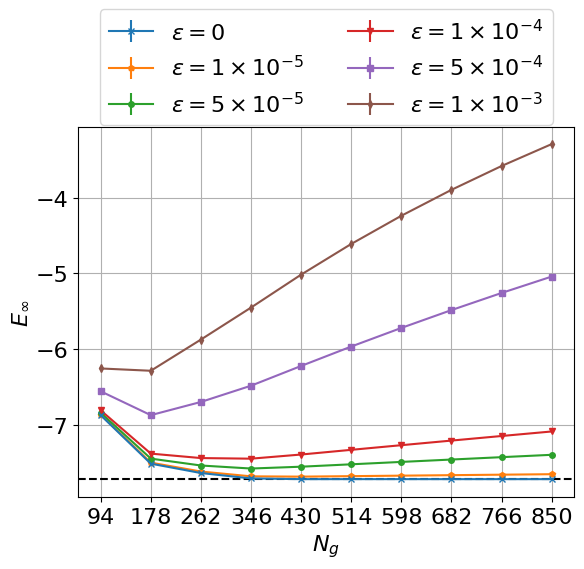

In [112]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.plot(gate_ct, val_list_id, label = r'$\epsilon = 0$')
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt = next(marker), markersize=4, label = r'$\epsilon = 0$')
for rt in range(len(base_expo)):
    #ax.plot(gate_ct, np.array(noisy_data_val['%s'%rt]), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
    #ax.plot(gate_ct, np.multiply(exp_off[rt], val_list_id), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    #diff =  np.multiply(exp_off[rt], val_list_id) - np.array(noisy_data_val['%s'%rt])
    #ax.plot(gate_ct, diff, label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
ax.set_xlabel(r'$N_g$')
ax.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
plt.legend(ncol = 2, loc = "upper center", bbox_to_anchor = (0.5, 1.35))
#ax.set_yscale('log')
plt.grid()
plt.savefig('noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

In [98]:
n_lay = 10

In [99]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(b * x)

In [100]:
# Define exponential model
def lin_model(x, a, b):
    return a * x + b

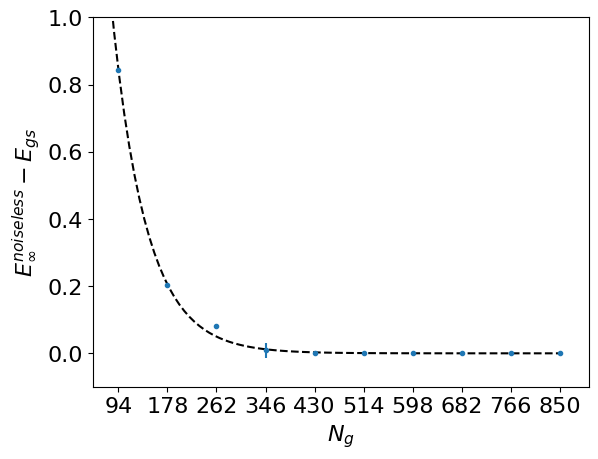

In [ ]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#plt.plot(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 'o')
plt.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, yerr = val_list_ids[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
#pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5))
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5), sigma=np.divide(val_list_ids[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5), absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)

a_err = np.exp(b_er)
b_err = a_er

y_fitt = exp_model(gate_ctt[0:n_lay], np.exp(b), a)

residuals = np.array(val_list_idm[0:n_lay]) - g_en5 - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(val_list_ids[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.array(np.array(val_list_idm[0:n_lay]) - g_en5)-np.mean(np.array(val_list_idm[0:n_lay]) - g_en5))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([50,900])
ax.set_ylim([-0.1, 1])
#plt.savefig('COBYLA_plots/noiseless_conv_en_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

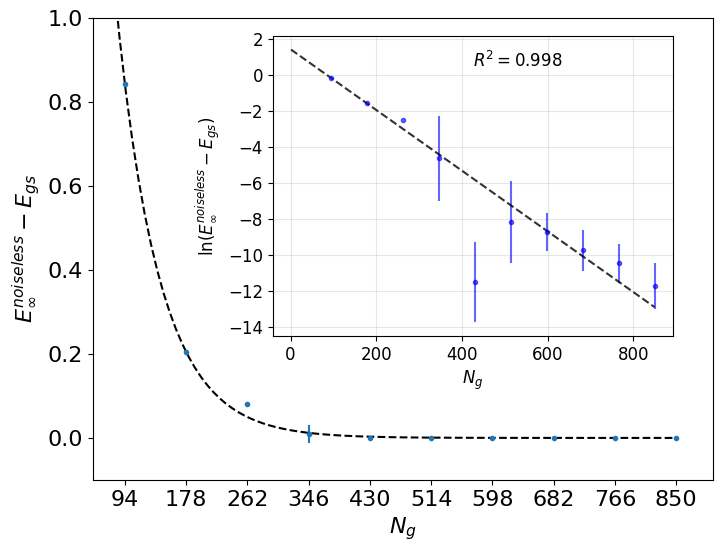

In [ ]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.35, 0.35, 0.5, 0.5])  # [left, bottom, width, height]

# Main plot
ax.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 
             yerr=val_list_ids[0:n_lay], fmt='.')

# Fit model with weights
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], 
                  np.log(np.array(val_list_idm[0:n_lay]) - g_en5), 
                  sigma=np.divide(val_list_ids[0:n_lay], 
                                np.array(val_list_idm[0:n_lay]) - g_en5), 
                  absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

# Plot fitted exponential model in main axes
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)
ax.plot(x_fit, y_fit, '--k', lw=1.5)

# Inset: log-linear plot
y_data = np.array(val_list_idm[0:n_lay]) - g_en5
inset_ax.errorbar(gate_ctt[0:n_lay], np.log(y_data), 
                 yerr=np.divide(val_list_ids[0:n_lay], y_data), 
                 fmt='.', color='blue', alpha=0.6)
inset_ax.plot(x_fit, np.log(y_fit), '--k', lw=1.5, alpha=0.8)

# Main axes settings
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')
ax.set_xlim([50,900])
ax.set_ylim([-0.1, 1])

# Inset axes settings
inset_ax.set_xlabel(r'$N_g$', fontsize=12)
inset_ax.set_ylabel(r'$\ln(E_{\infty}^{noiseless} - E_{gs})$', fontsize=12)
inset_ax.tick_params(axis='both', which='major', labelsize=12)
inset_ax.grid(True, alpha=0.3)

# Add R² value to inset
r_squared_text = f'$R^2={r_sq:.3f}$'
inset_ax.text(0.5, 0.95, r_squared_text, transform=inset_ax.transAxes, 
              fontsize=12, verticalalignment='top')

#plt.savefig('noiseless_conv_en_fit_COBY_inset.pdf', bbox_inches = 'tight')

plt.show()

In [71]:
print(np.exp(b), a_err, a, b_err)

4.1054927116664945 1.0000000000051885 -0.016844785431361663 5.3908787387344883e-14


In [72]:
print(r_sq, chi_sq)

0.9984599875748347 3814165199.799569


In [73]:
ss_res

0.0009688482514752288

In [74]:
a

-0.016844785431361663

In [75]:
b

1.4123257629042598

In [76]:
a_er

5.3908787387344883e-14

In [77]:
b_er

5.188516091625195e-12